In [1407]:
import numpy as np
from numpy import matlib
import scipy.stats

import numba
import tqdm
import multiprocessing
import scipy
from scipy.fft import ifft, ifft2, ifftn, irfft, irfftn


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import time
t1 = time.time()

In [1408]:
%load_ext line_profiler


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [1409]:
# (np.random.geometric([1,1/6],(1000,2))-1).mean(0)

## Simulation


In [1410]:
# @numba.njit
def step(calc_flux, population, t, *args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''
    flux = calc_flux( population, *args)[0]
    flux_sum = np.sum(flux)
    t = np.random.exponential(1. / flux_sum)
    rxn_prob = flux/flux_sum
    rxn = sample_rxns(rxn_prob)
    return rxn, t

def sample_rxns(prob_arr):
    '''
    Takes prob_arr and
    returns an randomly sampled index according to 
    the probabilities specificed in prob_arr
    '''
    num = np.random.rand()
    sent = 0
    tot = 0.
    while tot < num:
        tot = tot + prob_arr[sent]
        sent = sent + 1
    return sent - 1


In [1411]:
# @numba.njit
def step_with_queued(calc_flux,population,t,queued_reactions,queued_reaction_times,export_arr,*args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''

    if len(queued_reactions)==0:
        return step(calc_flux,population,t,*args)
    else:
        # 
        population = np.copy(population)
        population_orig = np.copy(population)
        queued_reaction_times = np.copy(queued_reaction_times)

        init_flux = calc_flux( population, *args)[0]
        n_rxn = len(init_flux)
        fluxes = np.zeros((len(queued_reactions)+1,n_rxn))
        fluxes[0] = calc_flux( population, *args)[0]
        for q in range(len(queued_reactions)):
            population += export_arr[queued_reactions[q]]
            fluxes[q+1] = calc_flux( population, *args)[0]

        queued_reaction_times = np.concatenate(([t],queued_reaction_times))
        flux_sums = fluxes[:-1] * np.diff(queued_reaction_times)[:,None]
        flux_sums = np.concatenate((np.zeros(n_rxn)[None,:],flux_sums))
        flux_cumsums = np.cumsum(flux_sums,0)
        tot_flux_cumsum = flux_cumsums.sum(1)

        u = np.random.rand()
        flux = np.log(1/u)
        
        last_ind = np.where(tot_flux_cumsum<flux)[0][-1]
        dt = queued_reaction_times[last_ind]-t
        flux_orig = np.copy(flux)
        flux -= tot_flux_cumsum[last_ind]
        dtprime = flux/fluxes[last_ind].sum()
        dt += dtprime

        flux_sum = fluxes[last_ind]
        rxn_prob = flux_sum / flux_sum.sum()
        rxn = sample_rxns(rxn_prob)   
        return rxn, dt
# def markovian_simulate(calc_flux, update, population_0, t_arr, tau, \
#                        DELAYED_SPECIES_GENERATORS, export_arr,burst_events, tau_list=None,\
#                        return_full=False,*args):

def markovian_simulate(calc_flux, update, population_0, t_arr, tau, \
                       DELAYED_SPECIES_GENERATORS, export_arr,burst_events, burst_size_time_dep, tau_list=None,\
                       return_full=False,*args):
    '''
    Takes params and
    returns matrix of the number of counts for 
    a species j at time t[i]
    '''
    if isinstance(tau , list) or isinstance(tau , tuple) :
        n_delays = len(tau)
    else:
        tau = [tau]
        n_delays = 1
        
    niter = 0

    population_arr = np.zeros((len(t_arr), update.shape[1]))
    t = t_arr[0]
    population = population_0.copy()
    population_arr[0, :] = population
    t_list = []
    population_list = []
    rxn_list = []

    t_list.append(t)
    population_list.append(population)
    
#     print(burst_events)
#     print(update)
#     raise ValueError

    # Delay time queue
    if tau_list is None:
        tau_list = [[]]*n_delays
    tau_list_delay_inds = np.asarray(sum([[j]*len(x) for j,x in enumerate(tau_list)],[]))
    tau_list_all_delays = np.concatenate(tau_list)
    tau_list_sort = np.argsort(tau_list_all_delays).astype(int)

    tau_list_delay_inds = list(tau_list_delay_inds[tau_list_sort])
    tau_list_all_delays = list(tau_list_all_delays[tau_list_sort])
    
    while t < t_arr[-1]:
        event,dt = step_with_queued(calc_flux,population,t,\
                                    tau_list_delay_inds,tau_list_all_delays,\
                                    export_arr, *args)
        

        temp_t = t + dt
        
        # Check if an export event should slot in before t + dt
        while (len(tau_list_all_delays) != 0) and (temp_t > tau_list_all_delays[0]):
            population = population + export_arr[tau_list_delay_inds[0]]
            t = tau_list_all_delays[0]
            if t>t_arr[-1]:
                break
            t_list.append(t)
            population_list.append(population)
            rxn_list.append(-tau_list_delay_inds[0]-1)
            tau_list_all_delays.pop(0) # remove element
            tau_list_delay_inds.pop(0)

        if len(tau_list_all_delays)!=len(tau_list_delay_inds):
            raise ValueError
        
        # Perform event
        t = temp_t
        if event in burst_events:
            UPD = np.copy(update[event,:])
            bs_instantaneous = burst_size_time_dep(t)
            UPD[UPD>0] = np.random.geometric(1/(1+bs_instantaneous))-1
        else:
            UPD = update[event, :]
        population = population + UPD
        t_list.append(t)
        population_list.append(population)
        rxn_list.append(event)


        for j in range(n_delays):
            if event in DELAYED_SPECIES_GENERATORS[j]:
                tau_list_all_delays.append(t + tau[j])
                tau_list_delay_inds.append(j)
        tau_list_sort = np.argsort(tau_list_all_delays).astype(int)
        tau_list_delay_inds = list(np.asarray(tau_list_delay_inds)[tau_list_sort])
        tau_list_all_delays = list(np.asarray(tau_list_all_delays)[tau_list_sort])
    
    t_only_arr = np.asarray(t_list)
    population_list= np.asarray(population_list)
    for i in range(len(t_only_arr)):
        # print(t_only_arr)
        ind = np.searchsorted(t_arr, t_only_arr[i], side = 'right')
        # print(ind)
        population_arr[ind:] = np.array(population_list[i])
    if return_full:
        return population_arr,t_only_arr,population_list,rxn_list
    else:
        return population_arr


In [1412]:
def nondelay_wrapper(N,n,K_val,A_val,burst_size_time_dep,beta_val,gamma_val,initcond,number_of_cells=5000,simulation_time=5,ndel=50,t_arr=None):
# def nondelay_wrapper(N,n,K_val,A_val,b_val,beta_val,gamma_val,initcond,number_of_cells=5000,simulation_time=5,ndel=50):
#     print(beta_val)
    H,A,C,S,k,Hss,burst_events = sim_setup(N,n,K_val,A_val,beta_val,gamma_val)
#     H,A,C,S,k,Hss,burst_events = sim_setup(N,n,K_val,A_val,b_val,beta_val,gamma_val)
# 
    delayed_species = []
    DELAYED_SPECIES_GENERATORS = [[]]

    tau = []

    ####
    update_arr = S

#     print(S)
#     print(H)
#     print(A)
#     print(C)
#     print(k)
#     print(Hss)
#     print(burst_events)
    
    if t_arr is None:
        t_arr = np.linspace(0, simulation_time, ndel,endpoint=False)


    export_arr = np.zeros((len(delayed_species),N+n),dtype=int)


    samples = np.zeros((number_of_cells, len(t_arr), N+n))


    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    for i in tqdm.tqdm(range(number_of_cells)):
        population_0 = np.zeros(N+n,dtype=int)
        if initcond[0][0]=='thermalized':
            init_state_prob = Hss
        elif isinstance(initcond[0][1],int):
            init_state_prob = np.zeros(N)
            jinit = initcond[0][1]
            init_state_prob[jinit] = 1
        else:
            init_state_prob = initcond[0][1]
        if N>1:
            population_0[:N] = np.random.multinomial(1,init_state_prob,1)
        else:
            population_0[:N] = 1
        initial_promoter_state = np.where(population_0[:N]==1)[0][0]

        for j,condition in enumerate(initcond[1:]):
            if isinstance(condition[0],str):
                if condition[0]=='deterministic':
                    population_0[j+N] = condition[1]
                elif condition[0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[1])
            else:
                if condition[initial_promoter_state][0]=='deterministic':
                    population_0[j+N] = condition[initial_promoter_state][1]
                elif condition[initial_promoter_state][0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[initial_promoter_state][1])
        samples[i, :, :],event_t,event_x,_ = markovian_simulate(
            propfun_generic, update_arr, population_0, t_arr, \
            tau, DELAYED_SPECIES_GENERATORS, export_arr,burst_events,burst_size_time_dep,[[]],\
            True,(k,K_val,A_val,beta_val,gamma_val,N))
    return t_arr,samples,H,A,C,init_state_prob,burst_events


In [1413]:
def sim_setup(N,n,K_val,A_val,beta_val,gamma_val):

    H = np.zeros((N,N))
    for kv in K_val:
        H[kv[0],kv[1]] = kv[2]
    H -= np.diag(H.sum(1))

    A = np.zeros((N,n))
    for av in A_val:
        A[av[0],av[1]-1] = av[2]

    B = np.zeros((n,n))
#     print(beta_val)
    for bv in beta_val:
        B[bv[0]-1,bv[1]-1] = bv[2]
    B -= np.diag(B.sum(1))
    for gv in gamma_val:
        B[gv[0]-1,gv[0]-1] -= gv[1]
    

    Nspec = N+n
    Nrxn = len(K_val) + len(A_val) + len(gamma_val) + len(beta_val)
    S_mark = np.zeros((Nrxn,Nspec))
    k_mark = np.zeros(Nrxn)

    i=0
    burst_events = []
    for kv in K_val:
        S_mark[i,kv[0]] = -1
        S_mark[i,kv[1]] = 1
        k_mark[i] = kv[2]
        i+=1

    
#     for av,bv_ in zip(A_val,b_val):
#         if bv_ > 0:
#             burst_events += [i]
#             S_mark[i,av[1]+N-1] = bv_
#         else:
#             S_mark[i,av[1]+N-1] = 1
#         k_mark[i] = av[2]
#         i+=1

    for av in A_val:
        #note we assume there is just the one burst event! 
        burst_events += [i]
        S_mark[i,av[1]+N-1] = 1
        k_mark[i] = av[2]
        i+=1
        
    for bv in beta_val:
        S_mark[i,bv[0]+N-1] = -1
        S_mark[i,bv[1]+N-1] = 1
        k_mark[i] = bv[2]
        i+=1
        
    for gv in gamma_val:
        S_mark[i,gv[0]+N-1] = -1    
        k_mark[i] = gv[1]
        i+=1

    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    S_mark = S_mark.astype(int)

    return H,A,B,S_mark,k_mark,Hss,burst_events
    # print(B)

def propfun_generic(x,*args):
    # print(args)
    k,K_val,A_val,beta_val,gamma_val,N = args[0]
    nRxn = len(k)
    nCells = x.shape[0]

    a = np.zeros((nCells,nRxn),dtype=float)
    x = x.T
    a = a.T
    #######
    j = 0 
    for i in range(len(K_val)):
        a[j] = k[j] * x[K_val[i][0]]
        j+=1
    for i in range(len(A_val)):
        a[j] = k[j] * x[A_val[i][0]]
        j+=1
    for i in range(len(beta_val)):
        a[j] = k[j] * x[beta_val[i][0]+N-1]
        j+=1
    for i in range(len(gamma_val)):
        a[j] = k[j] * x[gamma_val[i][0]+N-1]
        j+=1
    # print(a)
    # print(x)
    # raise ValueError
    return a.T


In [1414]:
def get_g(limits):
    u = []
    mx = np.copy(limits)
    mx[-1] = mx[-1] // 2 + 1

    for i in range(len(mx)):
        l = np.arange(mx[i])
        u_ = np.exp(-2j*np.pi*l/limits[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    return g,mx


def ufun_mat(g,x,beta,gamma):
    U =  np.exp(-gamma * x) * g[1]
    return U

def ufun_generic(g,x,beta,gamma):
#     print()
    if np.isclose(beta, gamma):  # compute prefactors for the ODE characteristics.
        c_1 = g[0]  # nascent
        c_2 = x * beta * g[1]
    else:
        f = beta / (beta - gamma)
        c_2 = g[1] * f
        c_1 = g[0] - c_2
    U = (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
    return U

In [1415]:
def pss_wrapper(k,beta,gamma,burst_size_time_dep,t,mx,initcond):
    N=1
    n=2
    try:
        nT = len(t)
    except:
        nT = 1
        t = [t]
        
    g,mx_red = get_g(mx)
    g = np.asarray(g).T
    gf_initcond_prop = np.ones((g.shape[0],nT),dtype=np.complex128)

    ufuncs = [ufun_generic,ufun_mat]
    for j,condition in enumerate(initcond):
        if isinstance(condition[0],str): #Identical conditions for all states
            if condition[0]=='deterministic':
                initcond_gfun = lambda x: (x+1)**condition[1]
            elif condition[0]=='poisson':
                initcond_gfun = lambda x: np.exp(condition[1]*x)
            if condition[1]>0:
                for i in range(g.shape[0]):
                    gf_initcond_prop[i,:] *= initcond_gfun(ufuncs[j](g[i],t,beta,gamma)) #slow slow slow!
        else: 
            print(N)
            print(len(condition[0]))
            raise ValueError
    gf = gfun_numerical(g,t,k,beta,gamma,burst_size_time_dep)
    gf *= (gf_initcond_prop)
    gf = np.reshape(gf,np.concatenate((mx_red,[nT])).astype(int))
    Pss = irfftn(gf,axes=[0,1],s=mx)
#     Pss = Pss.squeeze()
    return Pss


In [1416]:

def gfun_numerical(g,t,k,beta,gamma,burst_size_time_dep):
    nT = len(t)
    gf_ = np.zeros((g.shape[0],nT),dtype=np.complex128)
    bvec = np.asarray([burst_size_time_dep(t_) for t_ in t])
    if not np.isclose(beta,gamma):
        f = beta/(beta-gamma)
        Uv = [np.exp(-beta * t), np.exp(-gamma * t)]
        Uv = [Uv[0],f*(Uv[1]-Uv[0])]
    else:
        Uv = np.exp(-beta * t)
        Uv = [Uv,t*Uv]
    
    
    for i in (range(g.shape[0])):
        t0 = 0
        y0 = np.zeros((N),dtype=np.complex128)
        Uvec = Uv[0]*g[i][0] + Uv[1]*g[i][1] #highly optimized: all characteristics are precomputed
        integ = intfun_trapz(t,Uvec,k,bvec)
        gf_[i,:] = integ
    return np.exp(gf_)

def intfun_trapz(tvec,Uvec,k,bvec):
    nT = len(tvec)
    bUmat = scipy.linalg.toeplitz(bvec,np.asarray([bvec[0]]+(nT-1)*[ 0]))
    bUmat=np.multiply(bUmat,Uvec)
    """
    This is heavily optimized. Toeplitz is fast. I've tried iterating over t,
    building numpy and scipy.sparse diag matrices, and a couple of other ideas.
    """
    
    bUmat = 1/(1-bUmat)-1
    
    integ = np.trapz(bUmat,tvec,axis=1)
    return k*integ


In [1804]:
conditional_colors = ('red','cadetblue','deeppink','khaki')
uncond_colors = ('lightgray','darkgray')
alf=0.5
def viz_nondelay(t_arr,samples,k,beta,gamma,burst_size_time_dep,initcond,t_pts = [0,2,5,10,49]):
    nt=len(t_pts)
    n=2
    N=1
    fig1,ax1=plt.subplots(nt,n,figsize=(8,12))
    
    
    Pss_all = []
    t1 = time.time()
#     mx = [64,32]
    mx = [int(samples[:,:,N+i].max()+4) for i in range(n)]
    Pss_joint = pss_wrapper(k,beta,gamma,burst_size_time_dep,t_arr,mx,initcond)[:,:,t_pts]
    Pss_all=[Pss_joint.sum(1-i) for i in range(n)]
    t2 = time.time()
    print('Runetime: {:.2f} seconds.'.format(t2-t1))
    
    for k,tind in enumerate(t_pts):
        t=t_arr[tind]

        X=samples[:,tind,:]

        ax1[k,0].set_ylabel('t = {:.2f}'.format(t))
        for i in range(n):
            mx = [1]*n

            ub = X[:,N+i].max() + 2
            mx[i] = int(ub)
            Pss = Pss_all[i][:,k]

            bins = np.arange(X[:,N+i].max()+6)-0.5
            hist,_ = np.histogram(X[:,N+i],bins,density=True)
            ax1[k,i].bar(bins[:-1]+0.5,hist,color=uncond_colors[0],alpha=alf)

            ax1[k,i].plot(Pss,color=uncond_colors[1])


            ax1[k,i].set_xticks([])
            ax1[k,i].set_yticks([])
    fig1.tight_layout()


In [1418]:
def burst_size_time_dep_fun(t,switch_times,burst_size_values):
    for st,bv in zip(reversed(switch_times),reversed(burst_size_values)):
        if t >= st:
            return bv
    return 0
    

In [1442]:
exp_reactor = scipy.stats.expon(0,1)
uni_reactor = scipy.stats.uniform(0,2)
x = np.linspace(0,1,102)[1:-1]
t_exp = exp_reactor.ppf(x)
t_uni = uni_reactor.ppf(x)

In [1647]:
model_colors = ['mediumaquamarine','mediumpurple','orchid']
fs = 18
lw=4
dims = (8,5)

In [1628]:
nsim = 10000


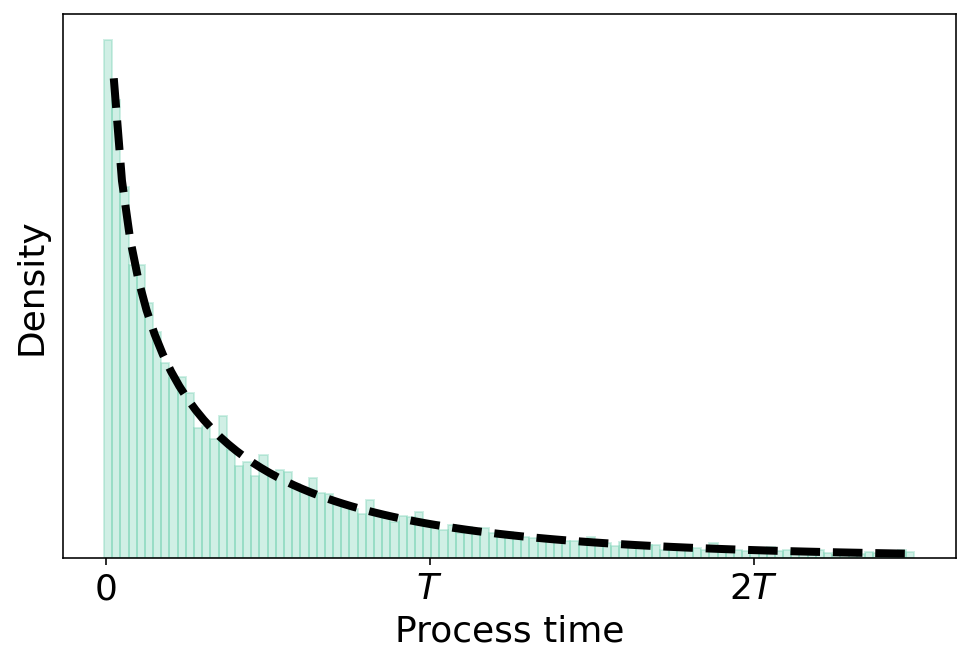

In [1649]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)

T = 2
t_ = np.linspace(0,5,100)

restime_exp = scipy.special.exp1(t_/T)/T
ax1.plot(t_,restime_exp,'k--',linewidth=lw)
restime_sim = scipy.stats.uniform(0,scipy.stats.expon(0,T).rvs(nsim)).rvs()
bins = t_-0.01

_=ax1.hist(restime_sim,bins,density=True,facecolor=model_colors[0],alpha=0.3,edgecolor=model_colors[0])
ax1.set_xlabel('Process time',fontsize=fs)
ax1.set_ylabel('Density',fontsize=fs)
ax1.set_yticks([])
ax1.set_xticks([0,T,2*T],['0',r'$T$',r'$2T$'],fontsize=fs)

In [1650]:
T

2

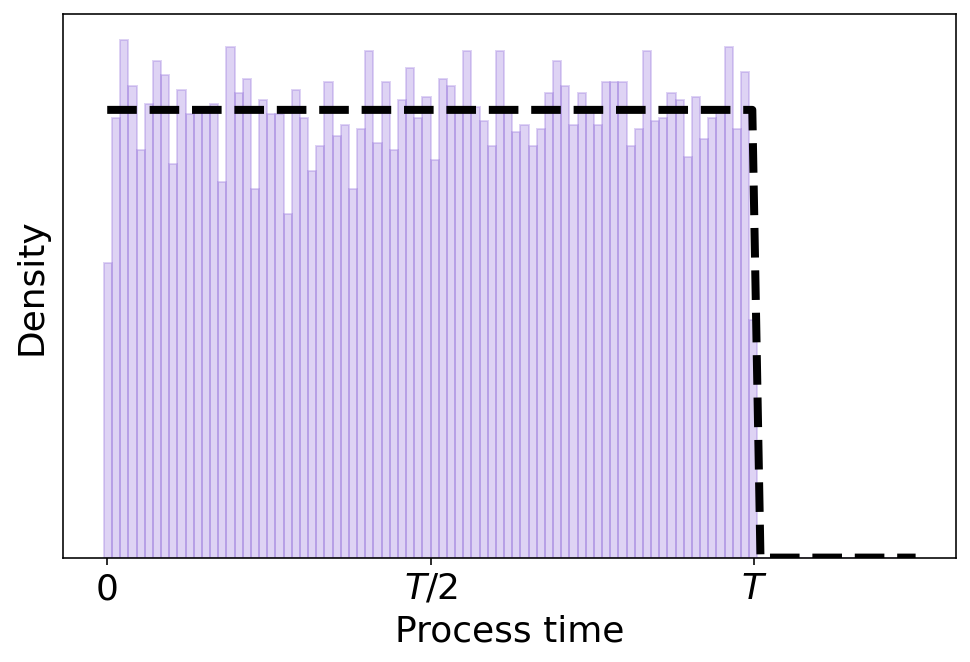

In [1651]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)

T = 2
t_ = np.linspace(0,2.5,100)
restime_uni = np.zeros_like(t_)
restime_uni[t_<= T] = 1/T
ax1.plot(t_,restime_uni,'k--',linewidth=lw)

restime_sim = (scipy.stats.uniform(0,T).rvs(nsim))
bins = t_-0.01

_=ax1.hist(restime_sim,bins,density=True,facecolor=model_colors[1],alpha=0.3,edgecolor=model_colors[1])
ax1.set_xlabel('Process time',fontsize=fs)
ax1.set_ylabel('Density',fontsize=fs)
ax1.set_yticks([])
ax1.set_xticks([0,T/2,T],['0',r'$T/2$',r'$T$'],fontsize=fs)

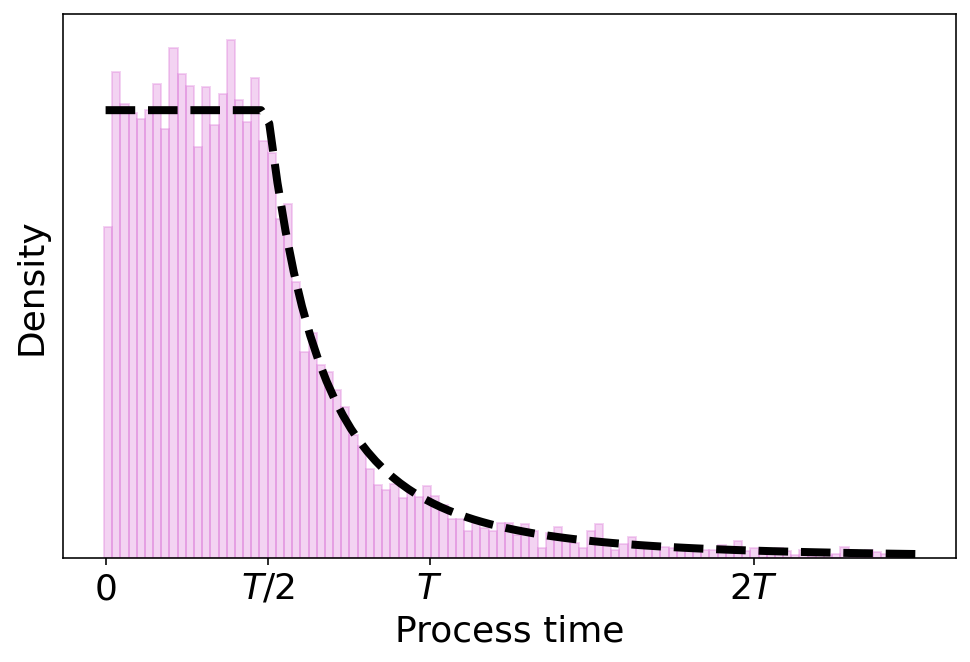

In [1652]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)

T = 2
t_ = np.linspace(0,5,100)
restime_lfr = np.zeros_like(t_)
restime_lfr[t_<= T/2] = 4/3/T
restime_lfr[t_> T/2] = T**2/(t_[t_> T/2])**3/6
ax1.plot(t_,restime_lfr,'k--',linewidth=lw)

restime_sim = T/(2*np.sqrt(1-(scipy.stats.uniform().rvs(nsim)))) * scipy.stats.uniform().rvs(nsim)
bins = t_-0.01

_=ax1.hist(restime_sim,bins,density=True,facecolor=model_colors[2],alpha=0.3,edgecolor=model_colors[2])
ax1.set_xlabel('Process time',fontsize=fs)
ax1.set_ylabel('Density',fontsize=fs)
ax1.set_yticks([])
ax1.set_xticks([0,T/2,T,2*T],['0',r'$T/2$',r'$T$',r'$2T$'],fontsize=fs)

let's simulate

In [1725]:
T = 5
n_cells = 500
uni_reactor = scipy.stats.uniform(0,T)
x = np.linspace(0,1,n_cells+2)[1:-1]
t_uni_quant = uni_reactor.ppf(x)
t_uni_sim = np.sort(uni_reactor.rvs(n_cells))

In [1726]:
burst_size_values

[2, 5, 1]

In [1728]:
N = 1
K_val = []
k=1
beta = 1.2
gamma = 3.14
n = 2
A_val =[[0,1,k]]
beta_val = [[1,2,beta]]
gamma_val = [[2,gamma]]

# T = 5

switch_times = [0,1,3]
burst_size_values = [2,5,1]

burst_size_time_dep = lambda t: burst_size_time_dep_fun(t,switch_times,burst_size_values)
muN0 = burst_size_values[0]*k/beta
muM0 = burst_size_values[0]*k/gamma

initcond = [['thermalized'],
            ['poisson',muN0],
            ['poisson',muM0]]
t_arr,samples,H,A,C,init_state_prob,burst_events = nondelay_wrapper(N,n,K_val,A_val,burst_size_time_dep,beta_val,gamma_val,initcond,simulation_time=T,number_of_cells=n_cells,t_arr = t_uni_sim)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 853.51it/s]


In [1729]:
t = np.linspace(0,T,100)
b_ = np.asarray([burst_size_time_dep(t_) for t_ in t])


In [1730]:
ct_colors = ['deepskyblue','gold','forestgreen']
fs = 18


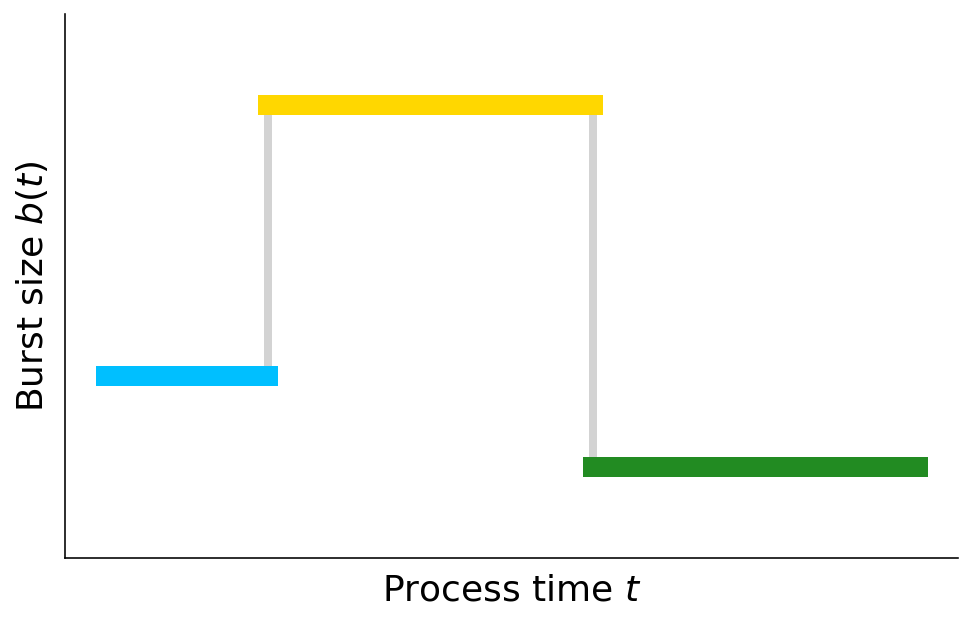

In [1740]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)
st = switch_times+[T]
for k in range(2):
    ax1.plot([st[k+1]]*2,[burst_size_values[k],burst_size_values[k+1]],color='lightgray',linewidth=4)
for k in range(3):
    ax1.plot([st[k],st[k+1]],[burst_size_values[k]]*2,linewidth=10,color=ct_colors[k])
ax1.set_ylabel(r'Burst size $b(t)$',fontsize=fs)
ax1.set_xlabel(r'Process time $t$',fontsize=fs)
ax1.set_ylim([0,6])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


In [1732]:
X = samples[:,:,1:].astype(int)

In [1733]:
X.shape

(500, 500, 2)

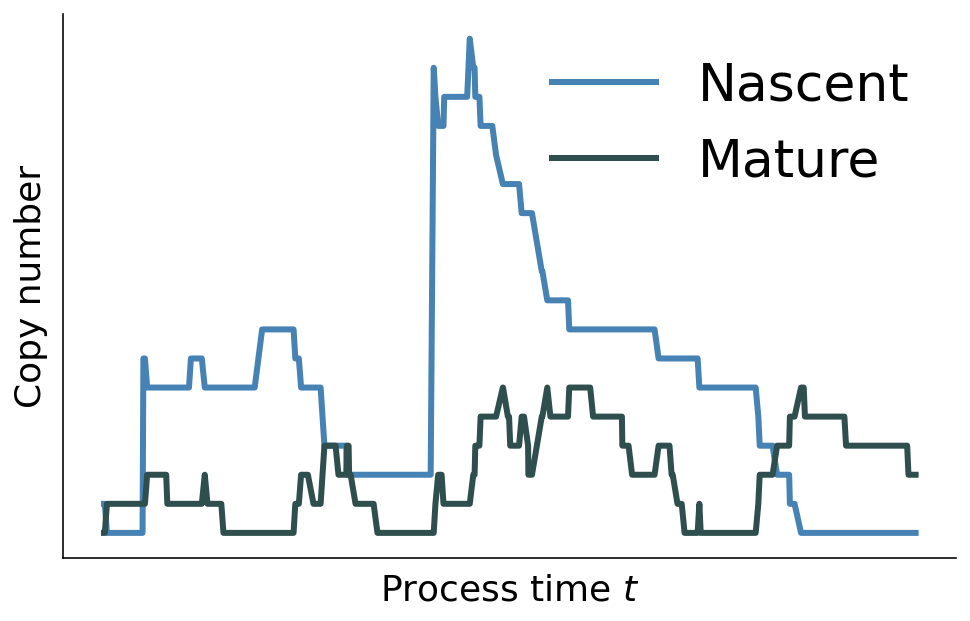

In [1734]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)
ax1.plot(t_arr,X[3,:,0],label='Nascent',linewidth=3,color="steelblue")
ax1.plot(t_arr,X[3,:,1],label='Mature',linewidth=3,color="darkslategray")
# st = switch_times+[T]
# for k in range(2):
#     ax1.plot([st[k+1]]*2,[burst_size_values[k],burst_size_values[k+1]],color='lightgray',linewidth=4)
# for k in range(3):
#     ax1.plot([st[k],st[k+1]],[burst_size_values[k]]*2,linewidth=10,color=ct_colors[k])
ax1.set_ylabel(r'Copy number',fontsize=fs)
ax1.set_xlabel(r'Process time $t$',fontsize=fs)
# ax1.set_ylim([0,10])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(fontsize=26,frameon=False)

In [1735]:
Y = X[np.arange(n_cells),np.arange(n_cells)]

In [1736]:
Y.shape

(500, 2)

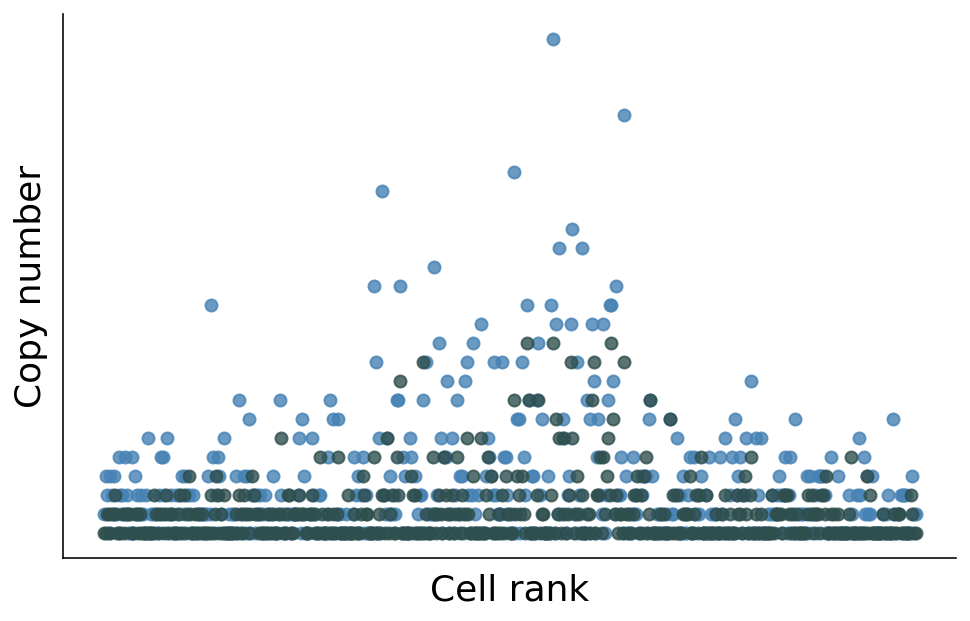

In [1737]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)
ax1.scatter(np.arange(n_cells),Y[:,0],label='Nascent',color="steelblue",alpha=.8)
ax1.scatter(np.arange(n_cells),Y[:,1],label='Mature',color="darkslategray",alpha=0.8)
# st = switch_times+[T]
# for k in range(2):
#     ax1.plot([st[k+1]]*2,[burst_size_values[k],burst_size_values[k+1]],color='lightgray',linewidth=4)
# for k in range(3):
#     ax1.plot([st[k],st[k+1]],[burst_size_values[k]]*2,linewidth=10,color=ct_colors[k])
ax1.set_ylabel(r'Copy number',fontsize=fs)
ax1.set_xlabel(r'Cell rank',fontsize=fs)
# ax1.set_ylim([0,10])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# ax1.legend(fontsize=26,frameon=False)

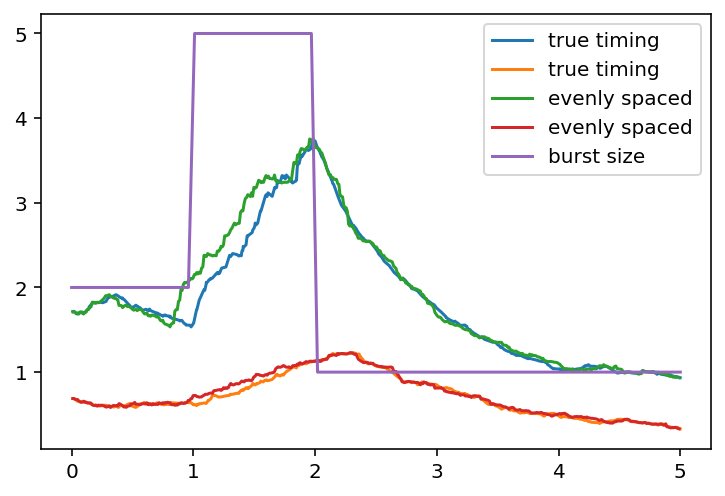

In [1671]:
plt.plot(t_arr,X.mean(0),label='true timing')
plt.plot(t_uni_quant,X.mean(0),label='evenly spaced')
plt.plot(t,b_,label='burst size')
plt.legend()

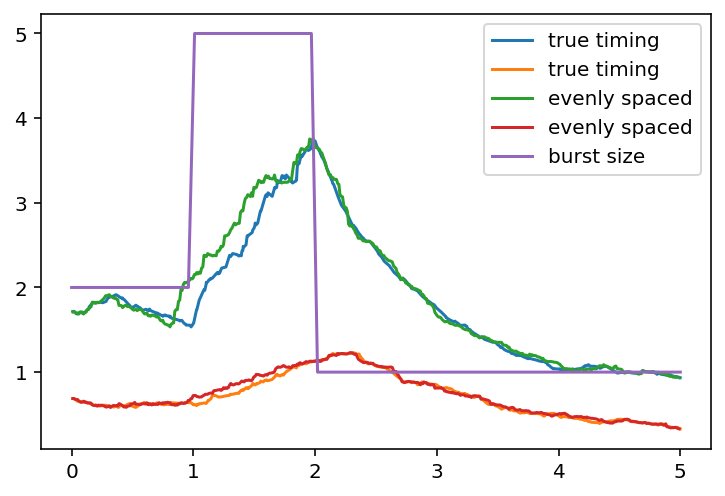

In [1672]:
plt.plot(t_arr,X.mean(0),label='true timing')
plt.plot(t_uni_quant,X.mean(0),label='evenly spaced')
plt.plot(t,b_,label='burst size')
plt.legend()

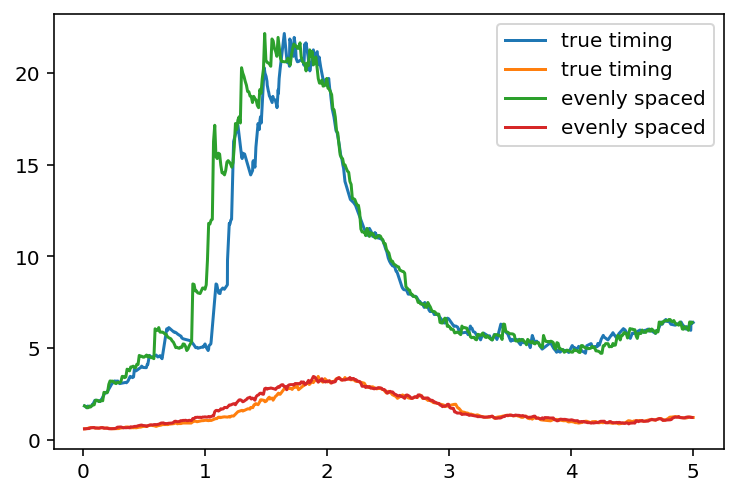

In [1654]:
plt.plot(t_arr,X.var(0),label='true timing')
plt.plot(t_uni_quant,X.var(0),label='evenly spaced')
plt.legend()

first dimension of x is cells! second is time points! don't forget this!

In [1396]:
# np.amax(X,0,1])

In [1721]:
# def inference(X,tvec,initcond):
#     n = 2
#     mx = [int(X[:,:,i].max()+5) for i in range(n)]
    
#     true_pars = np.log10(burst_size_values+[k,beta,gamma])
# #     objfun(true_pars,X,tvec,mx,initcond)

#     npar = 6
#     lb = np.asarray([-1.5]*npar)
#     ub = np.asarray([1.5]*npar)
#     bnd = scipy.optimize.Bounds(lb,ub)
#     x0 = np.random.rand(npar)*(ub-lb)+lb
# #     
#     onedimobj = lambda x:  objfun(x,X,tvec,mx,initcond)
#     print('Obj func value at correct parameters: {:.2f}.'.format(onedimobj(true_pars)))
#     print('Starting obj func value: {:.2f}.'.format(onedimobj(x0)))
#     res_arr = scipy.optimize.minimize(fun=onedimobj,x0=x0,bounds=bnd,method='L-BFGS-B',options={'maxiter':50,'disp':True})
#     return res_arr
# def objfun(log_pars,X,tvec,mx,initcond):
# #     print('two')
#     EPS = 1e-12
#     n_cells = len(tvec) #obviously change this if using a different grid
#     b1,b2,b3,k_,beta_,gamma_ = 10**log_pars
#     bs_vals = [b1,b2,b3]
    
#     burst_size_time_dep_test = lambda t: burst_size_time_dep_fun(t,switch_times,bs_vals)
#     Pss_joint = pss_wrapper(k_,beta_,gamma_,burst_size_time_dep_test,tvec,mx,initcond)
#     Pss_joint[Pss_joint<EPS]=EPS
#     nLL = negLogL(X,Pss_joint,n_cells)
#     return nLL
    
# def negLogL(X,Pss_joint,n_cells):
#     lik_tot = 0
#     for t_ in range(n_cells):
#         try:
#             lik_tot -= np.log(Pss_joint[X[t_,t_,0],X[t_,t_,1],t_])
#         except:
#             print(lik_tot)
#             print(Pss_joint[X[t_,t_,0],X[t_,t_,1],t_])
#             raise ValueError
#     return lik_tot


Note when this says "correct" parameters it means the parameters of the simulation. This will not necessarily be the "optimal" parameters, because the data and likelihood are at different time points.

In [1802]:
# res_arr=inference(X,t_uni_quant,initcond[1:])

In [ ]:
res_arr.x.round(2)

In [ ]:
np.log10(burst_size_values+[k,beta,gamma]).round(2)

True-...ish distribution

In [ ]:
#  viz_nondelay(t_uni_quant,samples,k,beta,gamma,burst_size_time_dep,initcond[1:],init_state_prob,t_pts = [25,50,70,100,125, 150,175,199])

In [ ]:
# b1,b2,b3,k_,beta_,gamma_ = 10**res_arr.x
# bs_vals = [b1,b2,b3]

# burst_size_time_dep_test = lambda t: burst_size_time_dep_fun(t,switch_times,bs_vals)

inferred distribution

In [ ]:
#  viz_nondelay(t_uni_quant,samples,k_,beta_,gamma_,burst_size_time_dep_test,initcond[1:],init_state_prob,t_pts = [25,50,70,100,125, 150,175,199])

initcond defines the initial condition. realistically we want to let this equilibrate a bit...

# Inference 

In [2000]:
T = 5
n_cells = 200
# t_true_sim = 
# exp_reactor = scipy.stats.expon(0,1)
uni_reactor = scipy.stats.uniform(0,T)
t_true_sim = np.sort(uni_reactor.rvs(n_cells))

In [2001]:
# t_true_sim = np.asarray([0]+list(t_true_sim))

In [2002]:
# t_true_sim

In [2003]:
N = 1
K_val = []
k=0.8
beta = 1.2
gamma = 3.14
n = 2
A_val =[[0,1,k]]
beta_val = [[1,2,beta]]
gamma_val = [[2,gamma]]


switch_times = [0,1,3]
burst_size_values = [2,5,1]

burst_size_time_dep = lambda t: burst_size_time_dep_fun(t,switch_times,burst_size_values)
muN0 = burst_size_values[0]*k/beta
muM0 = burst_size_values[0]*k/gamma

initcond = [['thermalized'],
            ['poisson',muN0],
            ['poisson',muM0]]
# initcond = [['thermalized'],
#             ['poisson',0],
#             ['poisson',20]]
t_arr,samples,H,A,C,init_state_prob,burst_events = nondelay_wrapper(N,n,K_val,A_val,burst_size_time_dep,beta_val,gamma_val,initcond,simulation_time=T,number_of_cells=n_cells,t_arr = t_true_sim)
X = samples[:,:,1:].astype(int)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1118.31it/s]


In [2034]:
def inference(X,tvec,switch_times,maxiter=20,disp=False):
    n = 2
    mx = [int(X[:,:,i].max()+5) for i in range(n)]
    
    true_pars = np.log10(burst_size_values+[k,beta,gamma])
    npar = 6
    lb = np.asarray([-1.5]*npar)
    ub = np.asarray([1.5]*npar)
    bnd = scipy.optimize.Bounds(lb,ub)
    x0 = np.random.rand(npar)*(ub-lb)+lb
    onedimobj = lambda x:  objfun(x,X,tvec,mx,switch_times)
    print('Obj func value at true parameters: {:.2f}.'.format(onedimobj(true_pars)))
    print('Starting obj func value: {:.2f}.'.format(onedimobj(x0)))
    res_arr = scipy.optimize.minimize(fun=onedimobj,x0=x0,bounds=bnd,method='L-BFGS-B',options={'maxiter':maxiter,'disp':disp})
    print('Obj func value at end of search: {:.2f}.'.format(res_arr.fun))
    return res_arr

def objfun(log_pars,X,tvec,mx,switch_times):
    EPS = 1e-12
    n_cells = len(tvec) #obviously change this if using a different grid
    b1,b2,b3,k_,beta_,gamma_ = 10**log_pars
    bs_vals = [b1,b2,b3]
    muN0 = b1*k_/beta_
    muM0 = b1*k_/gamma_

    initcond = [['poisson',muN0],
                ['poisson',muM0]]

    burst_size_time_dep_test = lambda t: burst_size_time_dep_fun(t,switch_times,bs_vals)
    Pss_joint = pss_wrapper(k_,beta_,gamma_,burst_size_time_dep_test,tvec,mx,initcond)
    Pss_joint[Pss_joint<EPS]=EPS
    nLL = negLogL(X,Pss_joint,n_cells)
    return nLL
    
def negLogL(X,Pss_joint,n_cells):
    lik_tot = 0
    for t_ in range(n_cells):
        try:
            lik_tot -= np.log(Pss_joint[X[t_,t_,0],X[t_,t_,1],t_])
        except:
            print(lik_tot)
            print(Pss_joint[X[t_,t_,0],X[t_,t_,1],t_])
            raise ValueError
    return lik_tot

Runetime: 0.30 seconds.


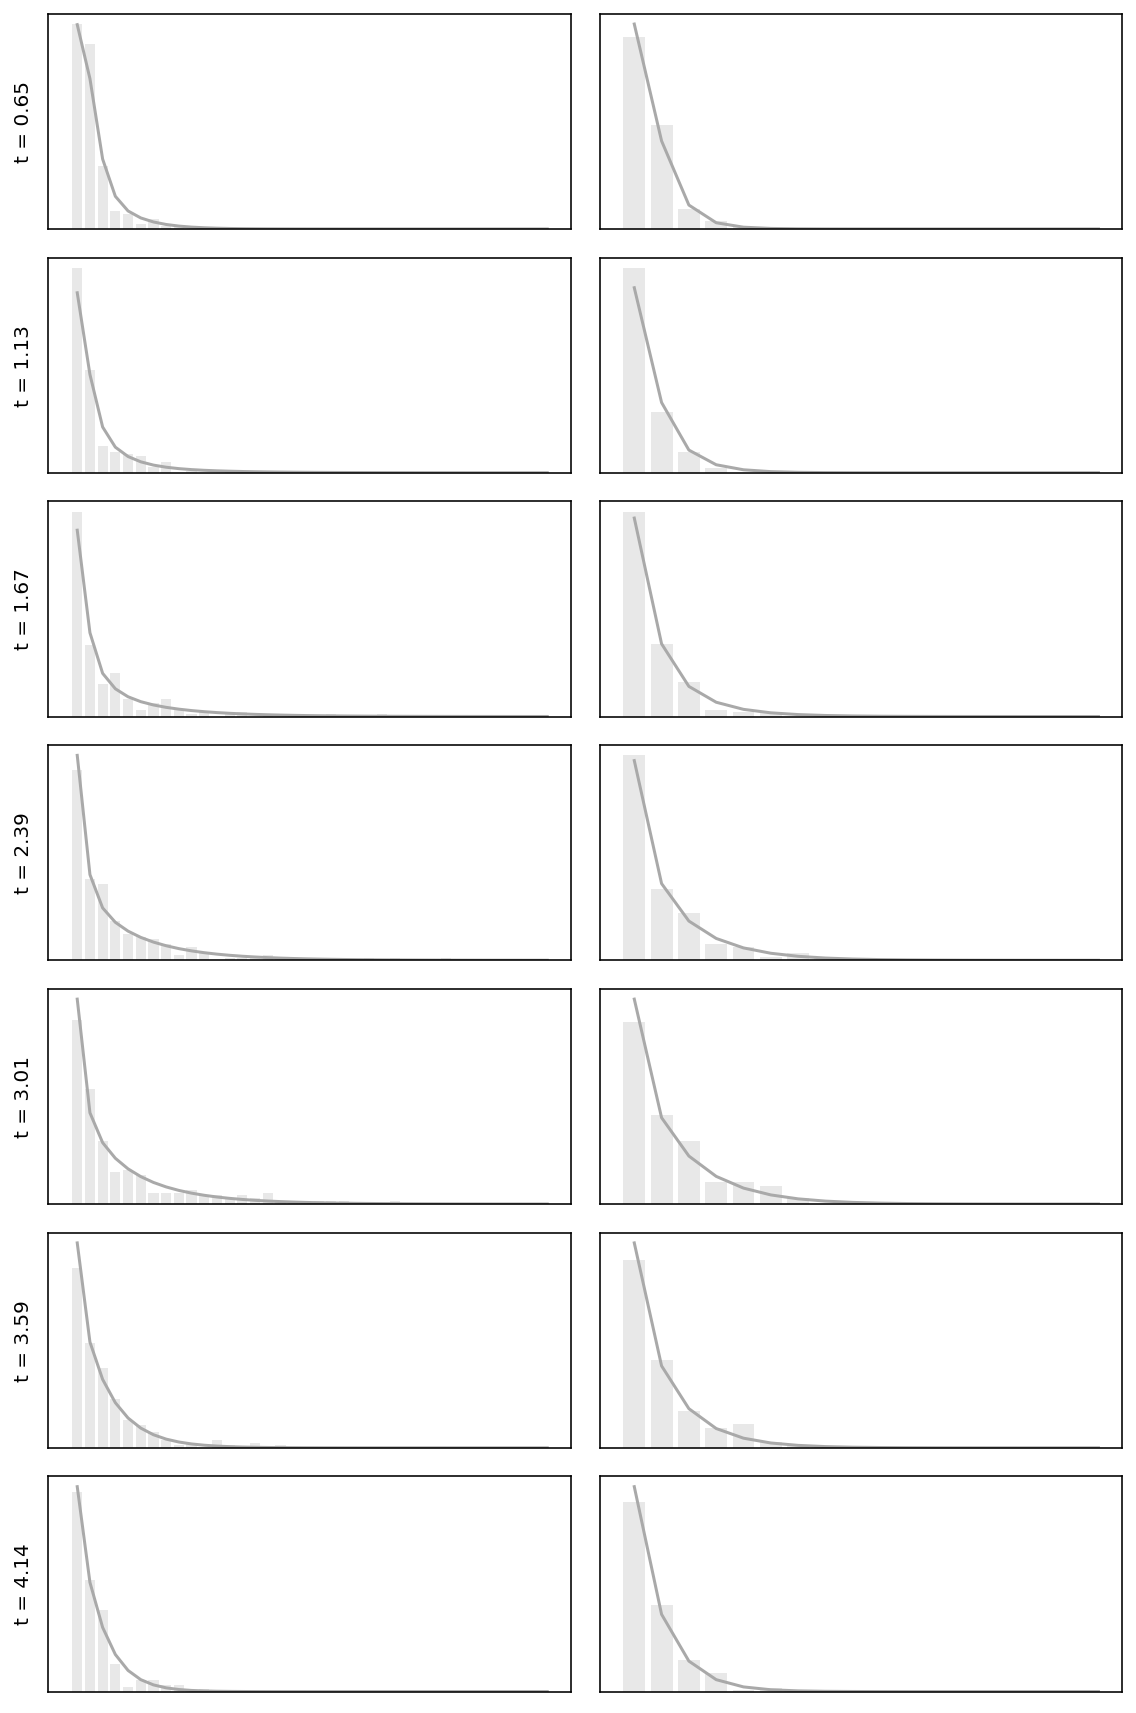

In [2007]:
viz_nondelay(t_true_sim,samples,k,beta,gamma,burst_size_time_dep,initcond[1:],t_pts = [25,50,70,100,125, 150,175])

In [2057]:
# b1,b2,b3,k_,beta_,gamma_ = 10**res_arr.x
# bs_vals = [b1,b2,b3]

# burst_size_time_dep_test = lambda t: burst_size_time_dep_fun(t,switch_times_uni,bs_vals)
# muN0 = b1*k_/beta_
# muM0 = b1*k_/gamma_

# initcond_ = [['poisson',muN0],
#             ['poisson',muM0]]

# viz_nondelay(t_uni,samples,k_,beta_,gamma_,burst_size_time_dep_test,initcond_,t_pts = [25,50,70,100,125, 150,175,199])

In [2020]:
np.log10(burst_size_values+[k,beta,gamma]).round(2)

array([ 0.3 ,  0.7 ,  0.  , -0.1 ,  0.08,  0.5 ])

In [2021]:
res_arr.x.round(2)

array([-0.01,  0.67, -0.29,  0.  , -0.02,  0.43])

In [2064]:
fracs_in_ct = np.asarray([switch_times[1]-switch_times[0],switch_times[2]-switch_times[1],0]).astype(float)
fracs_in_ct /= T
fracs_in_ct[-1] = 1-fracs_in_ct.sum()

uniform_orderstat_mean = np.arange(1,n_cells+1)/(n_cells+1)
t_uni = uni_reactor.ppf(uniform_orderstat_mean)
switch_times_uni = uni_reactor.ppf(np.cumsum([0]+list(fracs_in_ct[:-1])))

In [ ]:
res_arr_uni=inference(X,t_uni,switch_times_uni)

Obj func value at true parameters: 597.57.
Starting obj func value: 1606.82.


In [ ]:
exp_reactor = scipy.stats.expon(0,T)

In [ ]:
t_exp = exp_reactor.ppf(uniform_orderstat_mean)
switch_times_exp = exp_reactor.ppf(np.cumsum([0]+list(fracs_in_ct[:-1])))

In [ ]:
res_arr_exp=inference(X,t_exp,switch_times_exp)

In [ ]:
def lfr_ppf(x,T):
    t = np.ones_like(x)
    t[x<=2/3] = 3*T*x[x<=2/3]/4
    t[x>2/3] = T*np.sqrt(1/(12*(1-x[x>2/3])))
    return t

In [ ]:
t_lfr = lfr_ppf(uniform_orderstat_mean,T)
switch_times_lfr = lfr_ppf(np.cumsum([0]+list(fracs_in_ct[:-1])),T)

In [ ]:
res_arr_lfr=inference(X,t_lfr,switch_times_lfr)

In [ ]:
res_arr_lfr = res_arr_exp

In [ ]:
b1,b2,b3,k_,beta_,gamma_ = 10**res_arr_uni.x
bs_vals = [b1,b2,b3]

burst_size_time_dep_test = lambda t: burst_size_time_dep_fun(t,switch_times_uni,bs_vals)
muN0 = b1*k_/beta_
muM0 = b1*k_/gamma_

initcond_ = [['poisson',muN0],
            ['poisson',muM0]]

viz_nondelay(t_uni,samples,k_,beta_,gamma_,burst_size_time_dep_test,initcond_,t_pts = [25,50,70,100,125, 150,175,199])

In [ ]:
b1,b2,b3,k_,beta_,gamma_ = 10**res_arr_exp.x
bs_vals = [b1,b2,b3]

burst_size_time_dep_test = lambda t: burst_size_time_dep_fun(t,switch_times_exp,bs_vals)
muN0 = b1*k_/beta_
muM0 = b1*k_/gamma_

initcond_ = [['poisson',muN0],
            ['poisson',muM0]]

viz_nondelay(t_exp,samples,k_,beta_,gamma_,burst_size_time_dep_test,initcond_,t_pts = [25,50,70,100,125, 150,175,199])

In [ ]:
b1,b2,b3,k_,beta_,gamma_ = 10**res_arr_lfr.x
bs_vals = [b1,b2,b3]

burst_size_time_dep_test = lambda t: burst_size_time_dep_fun(t,switch_times_lfr,bs_vals)
muN0 = b1*k_/beta_
muM0 = b1*k_/gamma_

initcond_ = [['poisson',muN0],
            ['poisson',muM0]]

viz_nondelay(t_lfr,samples,k_,beta_,gamma_,burst_size_time_dep_test,initcond_,t_pts = [25,50,70,100,125, 150,175,199])